In [1]:
%matplotlib inline

# Import custom scripts

In [2]:
path_scripts = '/Users/sijo/Documents/Epidermis map/Scripts'

In [3]:
import sys
sys.path.append(path_scripts)

In [4]:
from EPI_misc_scripts_v1_1 import *
from EPI_affinity_propagation_v1_0 import *
from EPI_neg_binom_regression_v1_1 import *
from EPI_pseudotemporal_ordering_v1_0 import *

In [5]:
from matplotlib_venn import venn3, venn3_circles

# Initialize engines

In [6]:
from ipyparallel import Client

In [7]:
c = Client(profile='default')

In [8]:
dview = c[:]

In [9]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/sijo/Documents/Epidermis map/Scripts")')
dview.execute('from EPI_misc_scripts_v1_1 import *')
dview.execute('from EPI_affinity_propagation_v1_0 import *')
dview.execute('from EPI_neg_binom_regression_v1_1 import *')
dview.execute('from EPI_pseudotemporal_ordering_v1_0 import *')

<AsyncResult: execute>

# Import Data

In [10]:
exp_id = '201512281816'
path_input = '/Users/sijo/Documents/Epidermis map/Data/Input/TD_v1.2'
path_output = '/Users/sijo/Documents/Epidermis map/Data/Output/TD_v1.2'
path_figures = '/Users/sijo/Documents/Epidermis map/Figures/TD_v1.2'

In [11]:
seq_TD = loadData_v1(path_input, exp_id, 'seq_TD', 'DataFrame')
meta_TD = loadData_v1(path_input, exp_id, 'meta_TD', 'DataFrame')

In [12]:
seq = loadData_v1(path_input, '201509151726', 'seq', 'DataFrame')
meta = loadData_v1(path_input, '201509151726', 'meta', 'DataFrame')

In [13]:
s_groups_1st = loadData_v1(path_input, '201509151726', 's_groups_1st', 'Series')
s_groups_2nd = loadData_v1(path_input, '201509151726', 's_groups_2nd', 'Series')
g_groups_1st = loadData_v1(path_input, '201509151726', 'g_groups_1st', 'Series')

In [14]:
seq_sel_TD = loadData_v1(path_output, exp_id, 'seq_sel_TD', 'DataFrame')

In [15]:
s_groups_TD = loadData_v1(path_output, exp_id, 's_groups_TD', 'Series')
g_groups_TD = loadData_v1(path_output, exp_id, 'g_groups_TD', 'Series')

In [16]:
seq_comb = loadData_v1(path_output, exp_id, 'seq_comb', 'DataFrame')

In [17]:
s_groups_comb = loadData_v1(path_output, exp_id, 's_groups_comb', 'Series')

In [18]:
NBR_comb_bl_traces = loadData_from_pickle_v1(path_output, exp_id, 'NBR_comb_bl_traces')
NBR_comb_nbl_traces = loadData_from_pickle_v1(path_output, exp_id, 'NBR_comb_nbl_traces')

## Colormaps

In [19]:
cmap_TD2 = {1:'#b2182b',
            4:'#d6604d',
            2:'#f4a582',
            0:'#d1e5f0',
            3:'#4393c3',
            5:'#053061'}

In [20]:
cmap_comb = {1:'#2ca25f',
             2:'#d6604d',
             3:'#4393c3'}

# Clustering of Gli1-Tomato+/Sca1- and Sca1+ cells - heatmap

In [24]:
Counter(meta_TD.ix['cell_fraction',s_groups_TD.index])

Counter({'Gli1-Tomato+/Sca1+': 84, 'Gli1-Tomato+/Sca1-': 97})

In [28]:
g_groups_TD = AP_groups_reorder(g_groups_TD, [7, 2, 6, 0])

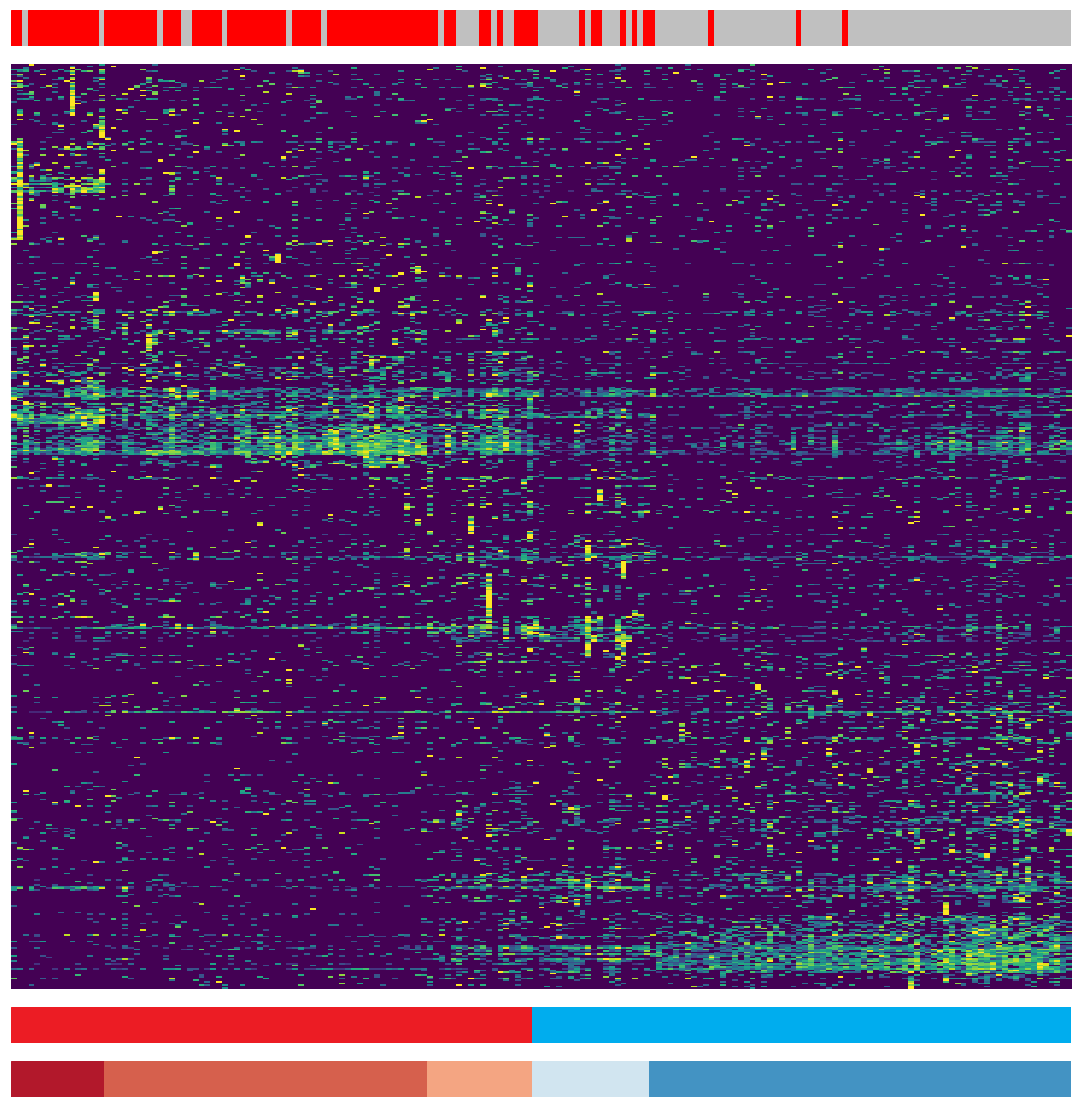

In [29]:
data = seq_sel_TD
metadata = meta_TD
cell_groups = s_groups_TD
gene_groups = g_groups_TD

#initialize figure

fig = plt.figure(facecolor = 'w', figsize = (20, 20))
gs = plt.GridSpec(ncols = 40, nrows = 60, wspace=0.0, hspace=0.0)

#bar with Sca1- and Sca1+ cells

ax = plt.subplot(gs[0:2,1:39])

ax.set_xlim(0, len(cell_groups.index))

for pos, ix in enumerate(cell_groups.index):
    
    if metadata.ix['cell_fraction', ix] == "Gli1-Tomato+/Sca1+":
        c = 'red'
    else:
        c = 'silver'
        
    ax.axvspan(pos, pos + 1, color = c)
    
clean_axis(ax)

#heatmap

ax = plt.subplot(gs[3:54,1:39])

ax.imshow(data.ix[gene_groups.index, cell_groups.index].apply(lambda x: x / np.max(x), axis = 1),
         cmap = plt.cm.viridis, aspect = 'auto', interpolation = 'nearest')

clean_axis(ax)

#bar with main compartments

ax = plt.subplot(gs[55:57,1:39])

ax.set_xlim(0, len(cell_groups.index))

for pos, gr in enumerate(cell_groups):
    
    if gr in [1,4,2]:
        c = '#EC1C24'
    else:
        c = '#00ADEE'
        
    ax.axvspan(pos, pos + 1, color = c)
    
clean_axis(ax)

#bar with populations

ax = plt.subplot(gs[58:60,1:39])

ax.set_xlim(0, len(cell_groups.index))

for pos, gr in enumerate(cell_groups):
    
    ax.axvspan(pos, pos + 1, color = cmap_TD2[gr])
    
clean_axis(ax)

figname = 'TD_v1.1_TD_heatmap.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Gene sets in basal IFE, TD and upper OB

In [21]:
def neg_binom_estimate_prob_v1P(traces, reference, dview, repeats = 100000):
    
    #########################
    
    def neg_binom_estimate_prob_helper_overexpr_v1(traces, gene, reference, repeats = repeats):
    
        #define output

        output = pd.DataFrame(index = [gene], columns = [gr for gr in traces.index if gr != reference])

        #iterate over groups

        for gr in [gr for gr in traces.index if gr != reference]:

            choice1 = np.random.choice(traces.ix[reference], size = repeats, replace = True)
            choice2 = np.random.choice(traces.ix[gr], size = repeats, replace = True)

            output.ix[gene, gr] = 1 - np.sum(choice2 > choice1) / float(repeats)

        return output
    
    #########################
    
    l = len(traces.index)
    
    output_tmp = dview.map_sync(neg_binom_estimate_prob_helper_overexpr_v1,
                                [traces.ix[g] for g in traces.index],
                                [g for g in traces.index],
                                [reference] * l,
                                [repeats] * l)
        
    output = pd.concat(output_tmp)
    
    return output

In [22]:
def neg_binom_get_binarized(pval, cutoff):
    
    output = pd.DataFrame(index = pval.index, columns = pval.columns).fillna(0)  
    output[pval<cutoff] = True
    
    return output

### Get summary

In [23]:
NBR_comb_bl_summary = neg_binom_summary_stats_v1P(NBR_comb_bl_traces, dview)

### Compare to Baseline

In [24]:
NBR_comb_bl_pval_bl = neg_binom_estimate_prob_v1P(NBR_comb_bl_traces, 'Baseline', dview)
NBR_comb_bl_pval_TD = neg_binom_estimate_prob_v1P(NBR_comb_bl_traces, 'TD', dview)
NBR_comb_bl_pval_OB = neg_binom_estimate_prob_v1P(NBR_comb_bl_traces, 'OB', dview)
NBR_comb_bl_pval_IFE = neg_binom_estimate_prob_v1P(NBR_comb_bl_traces, 'IFE', dview)

### Checkpoint

In [31]:
saveData_to_pickle_v1(NBR_comb_bl_pval_bl,path_output, exp_id, 'NBR_comb_bl_pval_bl')
saveData_to_pickle_v1(NBR_comb_bl_pval_TD,path_output, exp_id, 'NBR_comb_bl_pval_TD')
saveData_to_pickle_v1(NBR_comb_bl_pval_OB,path_output, exp_id, 'NBR_comb_bl_pval_OB')
saveData_to_pickle_v1(NBR_comb_bl_pval_IFE,path_output, exp_id, 'NBR_comb_bl_pval_IFE')

In [25]:
NBR_comb_bl_pval_bl_bin = neg_binom_get_binarized(NBR_comb_bl_pval_bl, 0.001)
NBR_comb_bl_pval_TD_bin = neg_binom_get_binarized(NBR_comb_bl_pval_TD, 0.001)
NBR_comb_bl_pval_OB_bin = neg_binom_get_binarized(NBR_comb_bl_pval_OB, 0.001)
NBR_comb_bl_pval_IFE_bin = neg_binom_get_binarized(NBR_comb_bl_pval_IFE, 0.001)

In [26]:
NBR_comb_bl_pval_bl_bin.sum()

IFE    165
TD     101
OB     411
dtype: int64

### Plot genes unique for TD

In [90]:
genes_TDvsBl = NBR_comb_bl_pval_bl_bin['TD'][NBR_comb_bl_pval_bl_bin['TD']==1].index
genes_TDvsIFE = NBR_comb_bl_pval_IFE_bin['TD'][NBR_comb_bl_pval_IFE_bin['TD']==1].index
genes_TDvsOB = NBR_comb_bl_pval_OB_bin['TD'][NBR_comb_bl_pval_OB_bin['TD']==1].index

In [91]:
genes_TD = list(set(genes_TDvsIFE) & set(genes_TDvsOB) & set(genes_TDvsBl))

In [92]:
len(genes_TD)

10

In [93]:
genes_TD = (summary.ix[genes_TD,'TD'] - summary.ix[genes_TD,['IFE','OB']].max(axis = 1)).sort_values()[-10:].index

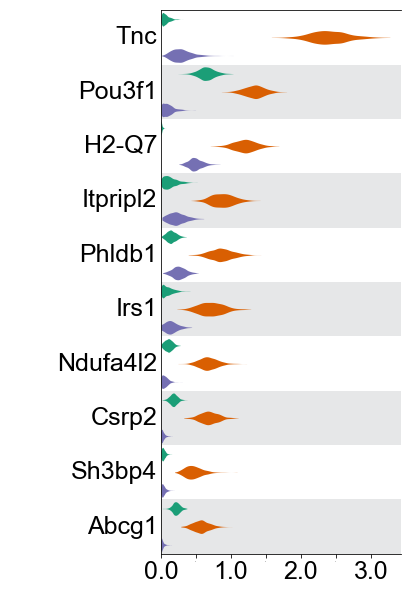

In [118]:
#define input variables

genes = genes_TD[::-1]
L = len(genes) * 3
traces = NBR_comb_bl_traces
cmap = {'IFE':'#1b9e77',
        'TD':'#d95f02',
        'OB':'#7570b3'}

#initialize figure

height = 10
width = 7

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1, 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#create gene name axis 
    
ax0 = plt.subplot(gs[0,0])
ax0.set_ylim(L - 0.5, -0.5)
clean_axis(ax0)

    
#create violin plot axis
    
ax1 = plt.subplot(gs[0,1])
    
ax1.spines['right'].set_color('none')

ax1.set_ylim(L - 0.5, -0.5)
ax1.yaxis.set_ticks_position('left')
ax1.yaxis.set_ticks([])


#iterate over genes
    
for ix, g in enumerate(genes):
    
    #print gene name
    
    ax0.text(0.975, (ix * 3) + 1, g, family = 'Arial', fontsize = 25, ha = 'right', va = 'center')
        
    #print background
        
    if ix % 2 == 0:
        ax1.axhspan(ix * 3 - 0.5, ix * 3 + 3.5, color = '#FFFFFF', zorder = 0)
            
    if ix % 2 == 1:
        ax1.axhspan(ix * 3- 0.5, ix * 3 + 3.5, color = '#E6E7E8', zorder = 0)
        
    #iterate over groups
    
    for pos, gr in enumerate(['IFE','TD','OB']):
        
        #print group traces
        
        violin = ax1.violinplot([np.log2(x) for x in traces.ix[g, str(gr)]],
                       positions = [ix * 3 + pos],
                       vert=False,
                       showextrema=False, 
                       widths=0.75)
        
        for v in violin['bodies']:
            v.set_edgecolor('black')
            v.set_facecolor(cmap[gr])
            v.set_linewidth(0.0)
            v.set_alpha(1.0)
        
for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
    if ix % 2 == 0:
        t.set_family('Arial')
        t.set_fontsize(25)
    else:
        t.set_fontsize(0)
        
ax1.set_xlim(left = 0)

figname = 'NBR_TD.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)